# Use CPU

In [1]:
import torch
device = "cpu" 
print(f"Using device: {device}")

Using device: cpu


# Load Dataset

In [2]:
dataset_path = f"dataset/Taskent"

from image_dataset import *

dataset = PetroTrainTestSplitDataset(folder_path=dataset_path)

train_dataset = dataset['train']
test_dataset = dataset['test']

print(len(train_dataset))
print(len(test_dataset))

print(train_dataset[0])
print(test_dataset[0])

__init__ PetroSubImageDataset: dataset/Taskent
         , image_indices=None
         , sub_image_size=480
__init__ BaseSubImageDataset with: dataset/Taskent/img
         , image_indices=None
         , sub_image_size=480
         , mask=False
__init__ BaseSubImageDataset with: dataset/Taskent/masks_machine
         , image_indices=None
         , sub_image_size=480
         , mask=True


/home/ubuntu/cs231n-project/image_dataset.py:211: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  images = torch.stack([torch.from_numpy(img) for img in images])


756
252
tensor([[[125, 132, 140,  ..., 132, 115, 113],
         [133, 135, 131,  ..., 129, 115, 113],
         [122, 122, 120,  ..., 134, 123, 115],
         ...,
         [134, 136, 126,  ..., 148, 148, 151],
         [133, 128, 121,  ..., 158, 157, 162],
         [136, 137, 139,  ..., 174, 171, 169]],

        [[125, 132, 140,  ..., 132, 115, 113],
         [133, 135, 131,  ..., 129, 115, 113],
         [122, 122, 120,  ..., 134, 123, 115],
         ...,
         [134, 136, 126,  ..., 148, 148, 151],
         [133, 128, 121,  ..., 158, 157, 162],
         [136, 137, 139,  ..., 174, 171, 169]],

        [[125, 132, 140,  ..., 132, 115, 113],
         [133, 135, 131,  ..., 129, 115, 113],
         [122, 122, 120,  ..., 134, 123, 115],
         ...,
         [134, 136, 126,  ..., 148, 148, 151],
         [133, 128, 121,  ..., 158, 157, 162],
         [136, 137, 139,  ..., 174, 171, 169]],

        [[  2,   2,   2,  ...,   2,   2,   2],
         [  2,   2,   2,  ...,   2,   2,   2],
    

In [3]:
from torch.utils.data import DataLoader
from clip_dino import DINOSegmentation, compute_iou
from dino_model import DINOPatchClassifier
from tqdm import tqdm
from einops import rearrange
import numpy as np

In [4]:
# Load smallest dino model. ViT-S/8. Here ViT-S has ~22M parameters and
# works on 8x8 patches.
dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
dino_model.eval().to(device)

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [5]:
from torchvision import transforms as T

transform = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# transform = T.Compose([
#     # T.Resize((480, 480)),
#     T.ToTensor(),
#     T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])


In [6]:
def get_dino_tokens_batch(X_batch):

    # X_batch.shape = [batch_size,480,480,3]

    X_batch = X_batch.float() / 255.0 # normalize
    # X_batch = X_batch.permute(0,3,1,2) # [N,H,W,C] -> [N,C,H,W]
    X_transform = torch.stack([
        transform(x) for x in X_batch
    ])
    X_transform = X_transform.to(device)

    w, h = X_transform.shape[2:]
    # 480,480

    with torch.no_grad():
        attn = dino_model.get_last_selfattention(X_transform)[:, :, 0, 1:]
        # (N,6,3600)
        # print(f"attn.shape={attn.shape}")
        nh, tokens = attn.shape[1:]
        w_feat, h_feat = w // 8, h // 8
        attn = attn.reshape(-1, nh, w_feat, h_feat)
        attn = torch.nn.functional.interpolate(attn, scale_factor=8, mode="nearest").cpu().numpy()
        all_tokens = dino_model.get_intermediate_layers(X_transform, n=1)[0]  # (N, 1+pixels, D)
    return all_tokens.cpu()

In [7]:
import numpy as np
import torch
from einops import rearrange
from scipy.stats import mode

def get_patchwise_mode(Y_batch):

    if isinstance(Y_batch, torch.Tensor):
        Y_batch = Y_batch.cpu().numpy()

    # Rearrange to 8x8 patches
    patches = rearrange(Y_batch, 'n (h ph) (w pw) -> n h w (ph pw)', ph=8, pw=8)
    # shape: (N, H//8, W//8, 64)

    # Compute mode along last axis
    patch_modes = mode(patches, axis=-1).mode  # shape: (N, H//8, W//8)

    return torch.tensor(patch_modes, dtype=torch.uint8)

# Load Model from checkpoint

In [8]:
num_classes = 18

# Load checkpoint
checkpoint_path = "checkpoints/model_checkpoint_epoch_50.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# Load model state
model = DINOPatchClassifier(num_classes=num_classes).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

loss_fn = torch.nn.CrossEntropyLoss()

print(f"Loaded model checkpoint from {checkpoint_path}")

Loaded model checkpoint from checkpoints/model_checkpoint_epoch_50.pth


# Pick Image

In [9]:
dataset = "train"
src_image_idx = 0 # algae
subimage_idx = 0




In [10]:

start_index = src_image_idx * 12

if dataset == "test":
  subimages = test_dataset[start_index:start_index+12]
else:
  subimages = train_dataset[start_index:start_index+12]

print(subimages.shape)

sample_X = subimages[subimage_idx,:-1]
sample_Y = subimages[subimage_idx,-1]

print(sample_X.shape)
print(sample_Y.shape)

torch.Size([12, 4, 480, 480])
torch.Size([3, 480, 480])
torch.Size([480, 480])


torch.Size([480, 480, 3])


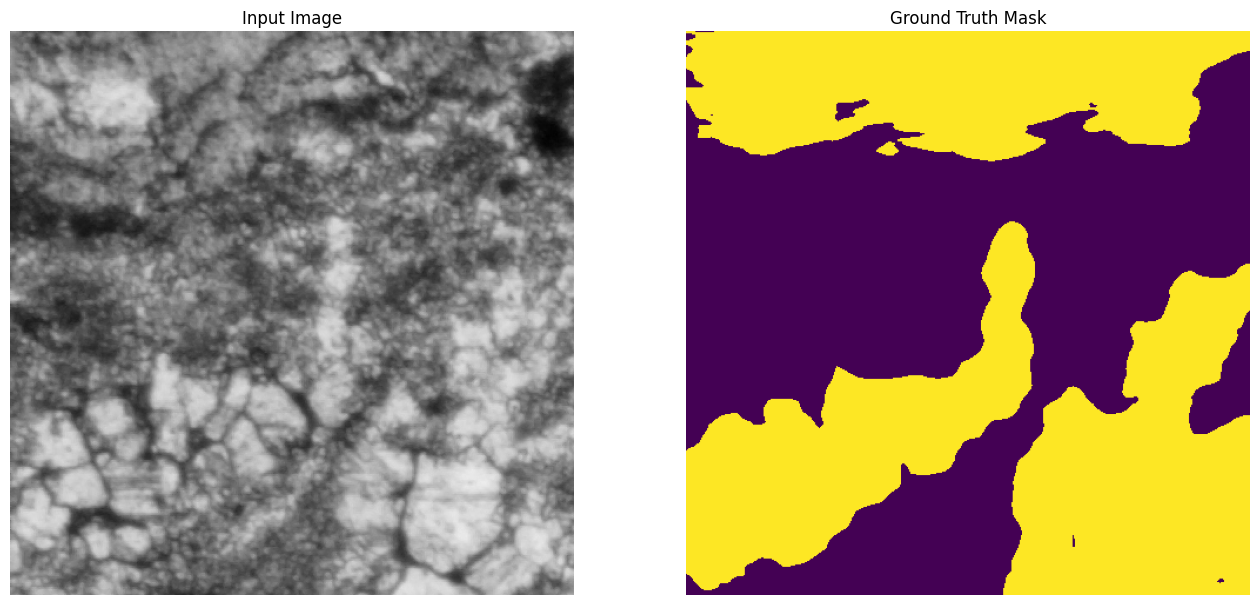

In [11]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

img_X = sample_X.clone()
img_X = rearrange(img_X, 'c h w -> h w c')
img_Y = sample_Y.clone()
img_Y = img_Y.cpu().numpy()
img_Y = Image.fromarray(img_Y)
img_Y = img_Y.convert("L")
img_Y = ImageOps.autocontrast(img_Y)

print(img_X.shape)
# print(sample_Y.shape)

# Create figure with two subplots side by side
plt.figure(figsize=(16, 8))

# Plot sample_X
plt.subplot(1, 2, 1)
plt.imshow(img_X)
plt.title('Input Image')
plt.axis('off')

# Plot sample_Y 
plt.subplot(1, 2, 2)
plt.imshow(img_Y)
plt.title('Ground Truth Mask')
plt.axis('off')

plt.show()



In [12]:
Y = get_patchwise_mode(sample_Y.unsqueeze(0))
Y = rearrange(Y, 'n h w -> (n h w)').to(device)

X = get_dino_tokens_batch(sample_X.unsqueeze(0).to(device))
X = X[:, 1:, :]
X_tokens_for_PCA = X.clone()
X = rearrange(X, 'n p d -> (n p) d').to(device)

logits = model(X)
loss = loss_fn(logits, Y)
preds = torch.argmax(logits, dim=1)

correct_val = (preds == Y).sum().item()

print(correct_val, correct_val*1.0/Y.size(0))

iou = compute_iou(preds.cpu().numpy(), Y.cpu().numpy(), num_classes)
print(iou)

2459 0.6830555555555555
0.05776669556246699


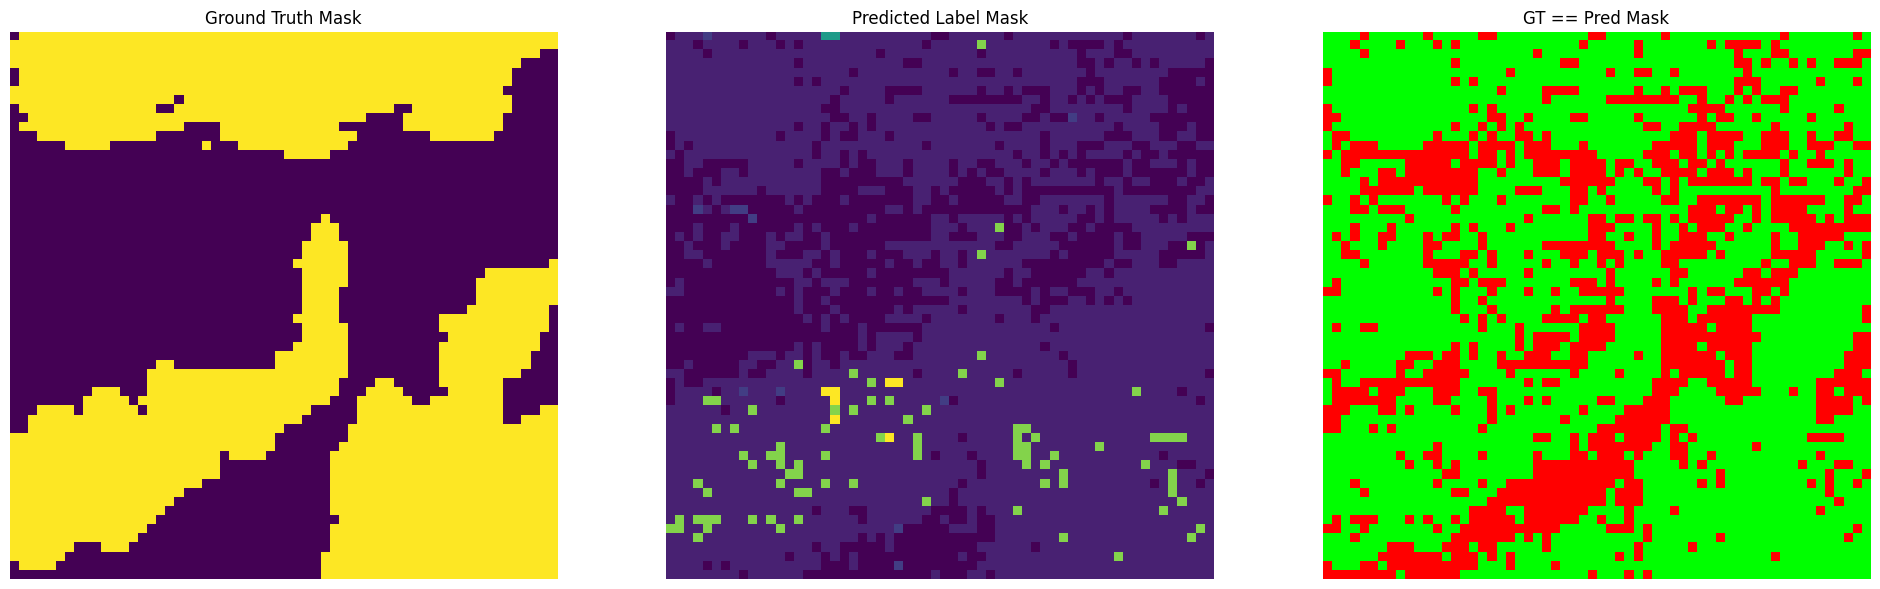

In [13]:
Y_pred = rearrange(preds, '(h w) -> h w', h = 60)
Y_true = rearrange(Y, '(h w) -> h w', h = 60)

Y_pred = Y_pred.cpu().numpy()
Y_true = Y_true.cpu().numpy()

Y_correct = Y_pred == Y_true

Y_pred = Image.fromarray(Y_pred.astype(np.uint8)).convert("L")
Y_pred = ImageOps.autocontrast(Y_pred)

Y_true = Image.fromarray(Y_true.astype(np.uint8)).convert("L")
Y_true = ImageOps.autocontrast(Y_true)

# Y_correct = Image.fromarray(Y_correct.astype(np.uint8)).convert("L")
# Y_correct = ImageOps.autocontrast(Y_correct)

# Create RGB image: green for correct, red for incorrect
correct_rgb = np.zeros((60, 60, 3), dtype=np.uint8)
correct_rgb[Y_correct] = [0, 255, 0]      # Green
correct_rgb[~Y_correct] = [255, 0, 0]     # Red


# Create figure with three subplots side by side
plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.imshow(Y_true)
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Y_pred)
plt.title('Predicted Label Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(correct_rgb, cmap='gray')
plt.title('GT == Pred Mask')
plt.axis('off')

plt.show()

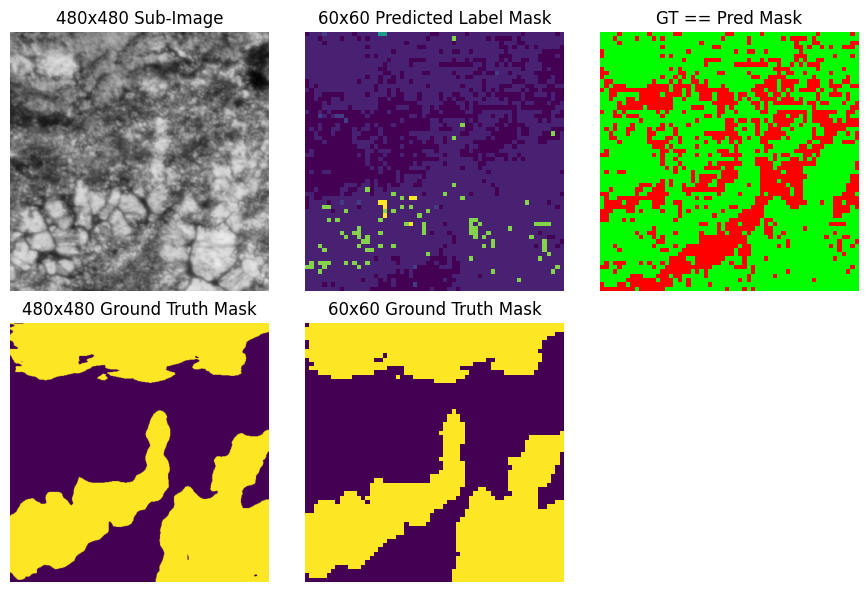

In [14]:
# Create figure with three subplots side by side
plt.figure(figsize=(9, 6))

plt.subplot(2, 3, 1)
plt.imshow(img_X)
plt.title('480x480 Sub-Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(Y_pred)
plt.title('60x60 Predicted Label Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(correct_rgb)
plt.title('GT == Pred Mask')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(img_Y)
plt.title('480x480 Ground Truth Mask')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(Y_true)
plt.title('60x60 Ground Truth Mask')
plt.axis('off')


plt.tight_layout()
plt.show()

# add PCA

In [15]:
with torch.no_grad():
  patch_tokens = X_tokens_for_PCA  # (N, D)

print(sample_X.shape)
print(X_tokens_for_PCA.shape)
print(patch_tokens.shape)

torch.Size([3, 480, 480])
torch.Size([1, 3600, 384])
torch.Size([1, 3600, 384])


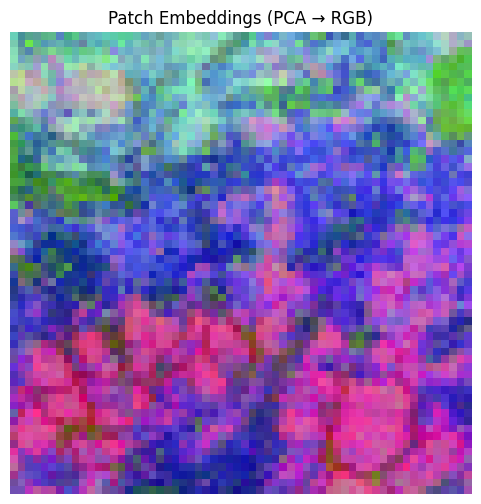

In [16]:
from sklearn.decomposition import PCA

np.random.seed(231)

# PCA
pca = PCA(n_components=3)
patch_pca = pca.fit_transform(patch_tokens.cpu().numpy()[0])

# Normalize PCA components to [0, 1] for RGB display
patch_rgb = (patch_pca - patch_pca.min(0)) / (patch_pca.max(0) - patch_pca.min(0))

# Reshape to image grid (60x60, 3)
patch_rgb_img = patch_rgb.reshape(60, 60, 3)

# Show as image
plt.figure(figsize=(6, 6))
plt.imshow(patch_rgb_img)
plt.axis('off')
plt.title("Patch Embeddings (PCA → RGB)")
plt.show()


# All plots

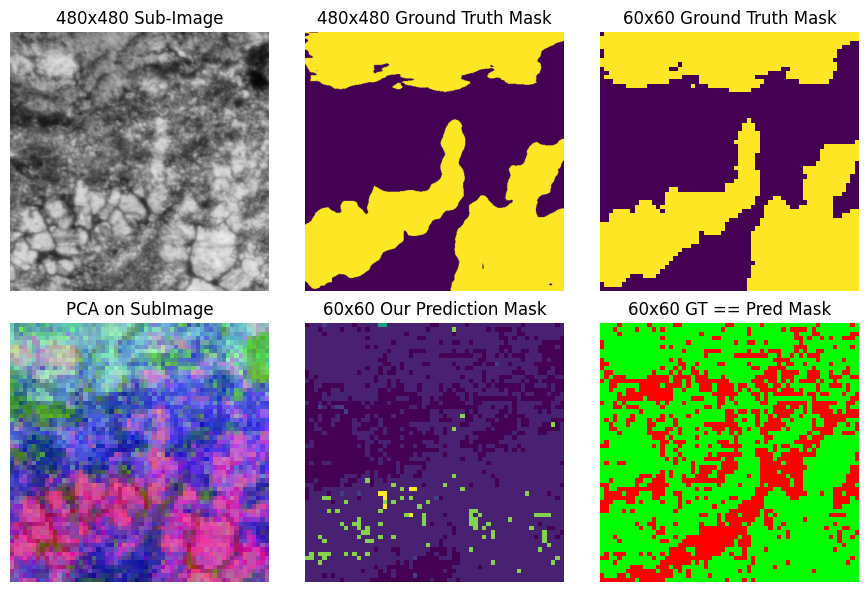

In [17]:
idx = 0

# Create figure with three subplots side by side
plt.figure(figsize=(9, 6))

idx+=1
plt.subplot(2, 3, idx)
plt.imshow(img_X)
plt.title('480x480 Sub-Image')
plt.axis('off')

idx+=1
plt.subplot(2, 3, idx)
plt.imshow(img_Y)
plt.title('480x480 Ground Truth Mask')
plt.axis('off')

idx+=1
plt.subplot(2, 3, idx)
plt.imshow(Y_true)
plt.title('60x60 Ground Truth Mask')
plt.axis('off')


idx+=1
plt.subplot(2, 3, idx)
plt.imshow(patch_rgb_img)
plt.title("PCA on SubImage")
plt.axis('off')

idx+=1
plt.subplot(2, 3, idx)
plt.imshow(Y_pred)
plt.title('60x60 Our Prediction Mask')
plt.axis('off')

idx+=1
plt.subplot(2, 3, idx)
plt.imshow(correct_rgb)
plt.title('60x60 GT == Pred Mask')
plt.axis('off')



plt.tight_layout()
plt.show()

In [18]:
print(sample_Y.numpy())

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
